### From SAV to LOVE

# HW№3 Advanced CNN

Обучить СНС с помощью Transfer Learning на датасете Food-101  
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.  
Библиотеки: [Python, Tensorflow]

### Подключение библиотек и скриптов

In [ ]:
# For local Jupyter Notebook 
from IPython.core.display import display, HTML, Image
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For Google Colaboratory
%tensorflow_version 2.x

In [ ]:
import time

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Функция визуализации графиков

In [ ]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Enabling and testing the TPU

### Загрузка данных

In [ ]:
tfds.disable_progress_bar()

(train_ds, test_ds), ds_info = tfds.load('food101', 
                                         as_supervised=True, 
                                         with_info=True, 
                                         split=['train[:90%]', 
                                                'train[90%:]'],
                                         )

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8ZYPVO/food101-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8ZYPVO/food101-validation.tfrecord
Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Изучение датасета

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [ ]:
len(train_ds), len(test_ds)

(68175, 7575)

### Визуализация датасета

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

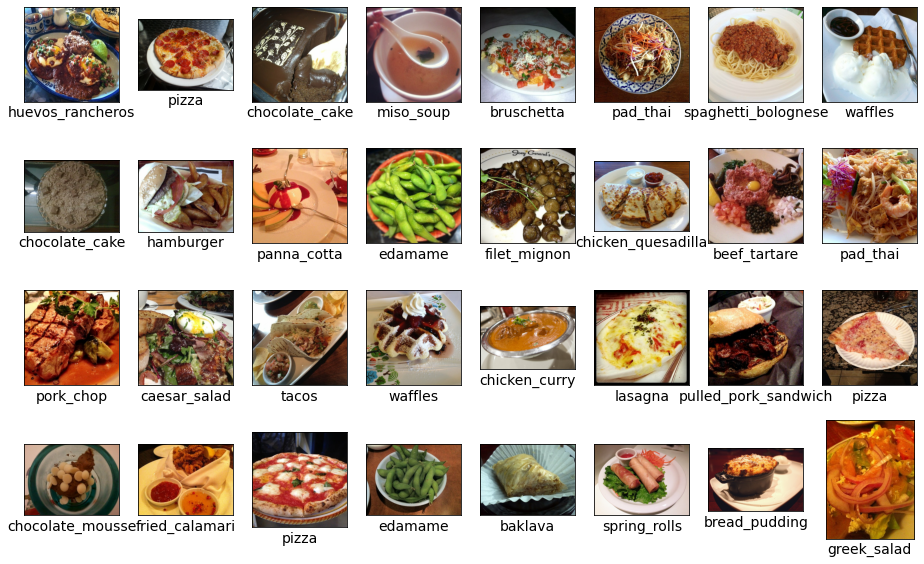

In [ ]:
ds = train_ds.take(32)

fig = plt.figure(figsize=(16, 10))
j = 0
for image, label in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(class_names[label])
    j += 1
plt.show()

### Создание пайплайна данных

In [ ]:
INP_SIZE = 224
NUM_EPOCHS = 3
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32) / 255. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

## Keras Applications
### Выбираем лучшую модель с предварительно обученными весами

In [ ]:
models = []

models.append(('MobileNetV2', tf.keras.applications.MobileNetV2(input_shape = (INP_SIZE, INP_SIZE, 3), include_top=False, weights='imagenet')))
models.append(('DenseNet201', tf.keras.applications.DenseNet201(input_shape = (INP_SIZE, INP_SIZE, 3), include_top=False, weights='imagenet')))
models.append(('Xception', tf.keras.applications.Xception(input_shape = (INP_SIZE, INP_SIZE, 3), include_top=False, weights='imagenet')))
models.append(('InceptionResNetV2', tf.keras.applications.InceptionResNetV2(input_shape = (INP_SIZE, INP_SIZE, 3), include_top=False, weights='imagenet')))

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
results = []

for name, pre_trained in models:
    pre_trained.trainable = True # Fine-tuning весов предобученной модели

    model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    pre_trained,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(1028, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax'),
    ])

    LEARNING_RATE = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+name, 
    write_graph=False, update_freq=100, profile_batch=0)

    start_time = time.time()

    history = model.fit(train_ds,
                    epochs=NUM_EPOCHS,
                    validation_data=test_ds,
                    callbacks=[tensorboard_callback]
                    )
    
    score_train = model.evaluate(train_ds, verbose=0)
    score_test = model.evaluate(test_ds, verbose=0)

    model_time = (time.time() - start_time)

    results.append((name, score_train[1], score_test[1], score_train[0], score_test[0], model_time, history))

Epoch 1/3
2130/2130 [==============================] - 415s 184ms/step - loss: 2.1474 - accuracy: 0.4794 - val_loss: 1.7085 - val_accuracy: 0.5659
Epoch 2/3
2130/2130 [==============================] - 391s 183ms/step - loss: 1.3554 - accuracy: 0.6451 - val_loss: 1.4722 - val_accuracy: 0.6246
Epoch 3/3
2130/2130 [==============================] - 372s 174ms/step - loss: 1.1457 - accuracy: 0.6949 - val_loss: 1.5023 - val_accuracy: 0.6202
Epoch 1/3
2130/2130 [==============================] - 728s 329ms/step - loss: 1.7008 - accuracy: 0.5904 - val_loss: 1.2448 - val_accuracy: 0.6802
Epoch 2/3
2130/2130 [==============================] - 679s 318ms/step - loss: 1.0148 - accuracy: 0.7360 - val_loss: 1.1432 - val_accuracy: 0.6998
Epoch 3/3
2130/2130 [==============================] - 698s 327ms/step - loss: 0.8104 - accuracy: 0.7839 - val_loss: 1.0874 - val_accuracy: 0.7156
Epoch 1/3
2130/2130 [==============================] - 856s 398ms/step - loss: 1.9565 - accuracy: 0.5320 - val_loss: 1

In [ ]:
pre_trained = pd.DataFrame(results)
pre_trained.columns = ['model', 'train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time', 'history']
pre_trained.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,train_loss,test_loss,time,history
2,Xception,0.83371,0.74378,0.61241,0.98005,2820.13410,<tensorflow.python.keras.callbacks.History object at 0x7fe829bc3150>
1,DenseNet201,0.79710,0.71531,0.73863,1.08804,2396.59410,<tensorflow.python.keras.callbacks.History object at 0x7fe84f2a5890>
3,InceptionResNetV2,0.79793,0.70935,0.87589,1.18020,2686.92306,<tensorflow.python.keras.callbacks.History object at 0x7fe848a26dd0>
0,MobileNetV2,0.66844,0.61997,1.24611,1.50344,1490.56205,<tensorflow.python.keras.callbacks.History object at 0x7fe8509532d0>


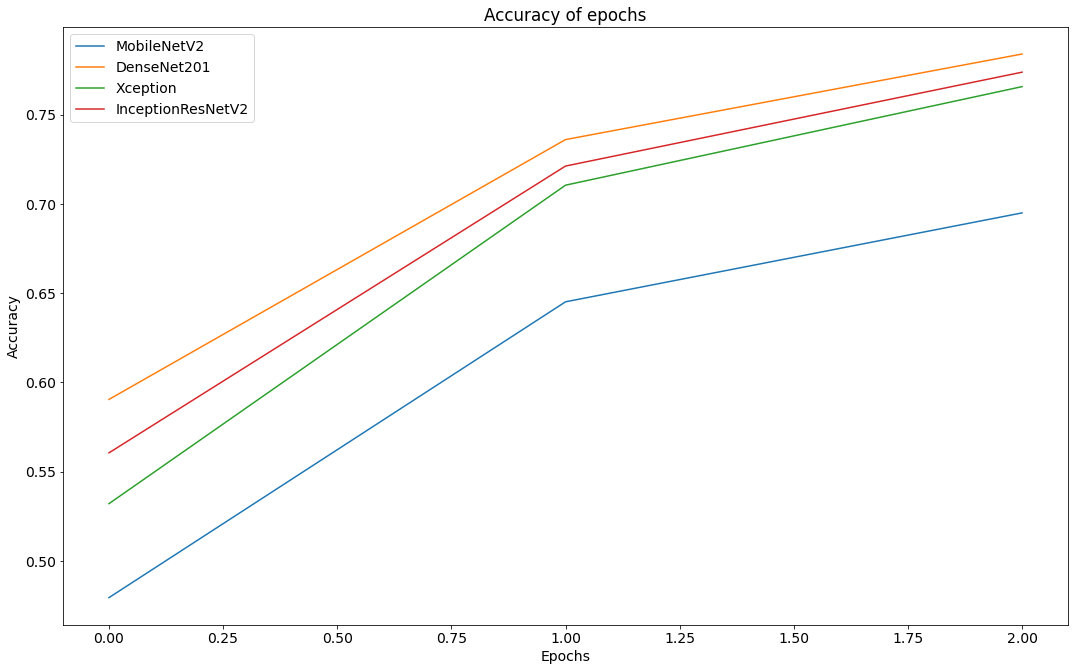

In [ ]:
plt.figure(figsize=(18, 11))
plt.plot(pre_trained.history[0].history['accuracy'], label='MobileNetV2')
plt.plot(pre_trained.history[1].history['accuracy'], label='DenseNet201')
plt.plot(pre_trained.history[2].history['accuracy'], label='Xception')
plt.plot(pre_trained.history[3].history['accuracy'], label='InceptionResNetV2')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

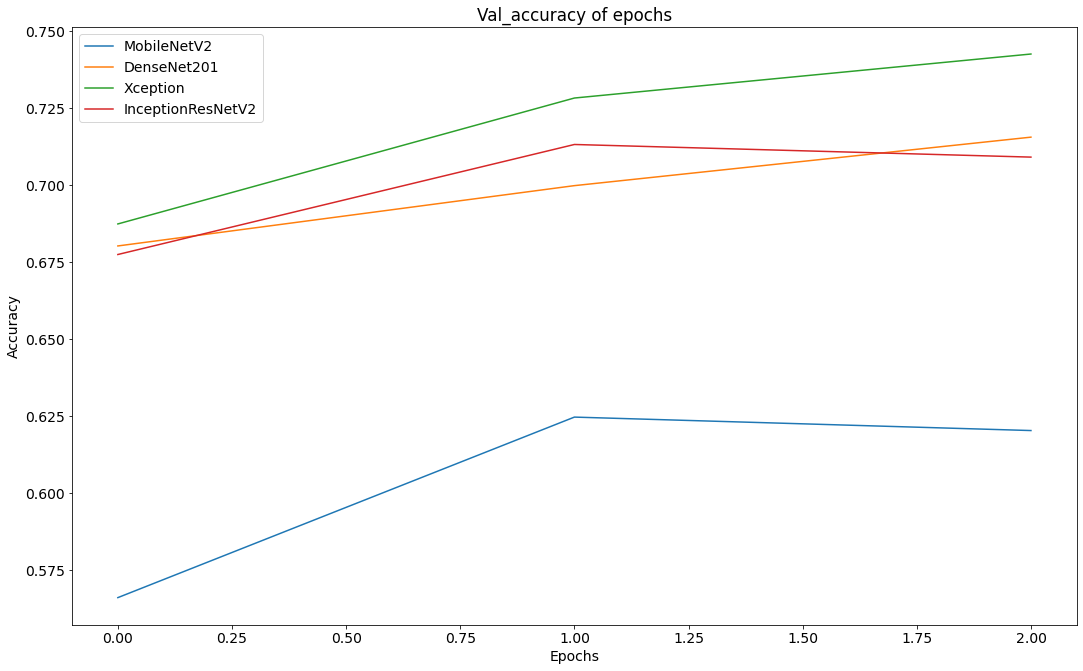

In [ ]:
plt.figure(figsize=(18, 11))
plt.plot(pre_trained.history[0].history['val_accuracy'], label='MobileNetV2')
plt.plot(pre_trained.history[1].history['val_accuracy'], label='DenseNet201')
plt.plot(pre_trained.history[2].history['val_accuracy'], label='Xception')
plt.plot(pre_trained.history[3].history['val_accuracy'], label='InceptionResNetV2')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Val_accuracy of epochs')
plt.show()

### TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Xception

In [ ]:
xc_model = tf.keras.applications.Xception(
    input_shape = (INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
xc_model.trainable = True # Fine-tuning весов предобученной модели

In [ ]:
model_2 = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.35),
xc_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(101, activation='softmax'),
])

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model_2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
%%time
start_time = time.time()
history_2 = model_2.fit(train_ds,
                    epochs=7,
                    validation_data=test_ds
                    )
model_time_2 = (time.time() - start_time)

Epoch 1/7
2130/2130 [==============================] - 862s 402ms/step - loss: 1.1653 - accuracy: 0.7202 - val_loss: 1.0111 - val_accuracy: 0.7312
Epoch 2/7
2130/2130 [==============================] - 855s 401ms/step - loss: 0.7566 - accuracy: 0.7944 - val_loss: 0.9734 - val_accuracy: 0.7470
Epoch 3/7
2130/2130 [==============================] - 857s 401ms/step - loss: 0.6269 - accuracy: 0.8256 - val_loss: 0.9924 - val_accuracy: 0.7483
Epoch 4/7
2130/2130 [==============================] - 856s 401ms/step - loss: 0.5289 - accuracy: 0.8501 - val_loss: 0.9420 - val_accuracy: 0.7599
Epoch 5/7
2130/2130 [==============================] - 857s 402ms/step - loss: 0.4536 - accuracy: 0.8703 - val_loss: 1.0123 - val_accuracy: 0.7507
Epoch 6/7
2130/2130 [==============================] - 856s 401ms/step - loss: 0.3836 - accuracy: 0.8888 - val_loss: 0.9824 - val_accuracy: 0.7627
Epoch 7/7
2130/2130 [==============================] - 839s 393ms/step - loss: 0.3244 - accuracy: 0.9052 - val_loss: 1

In [ ]:
model_time_2

6034.189064979553

In [ ]:
score_train_2 = model_2.evaluate(train_ds, verbose=0)
score_test_2 = model_2.evaluate(test_ds, verbose=0)

In [ ]:
print('Train loss:', score_train_2[0])
print('Train accuracy:', score_train_2[1])
print('Test loss:', score_test_2[0])
print('Test accuracy:', score_test_2[1])

Train loss: 0.21726113557815552
Train accuracy: 0.9348004460334778
Test loss: 1.0029572248458862
Test accuracy: 0.7639036178588867


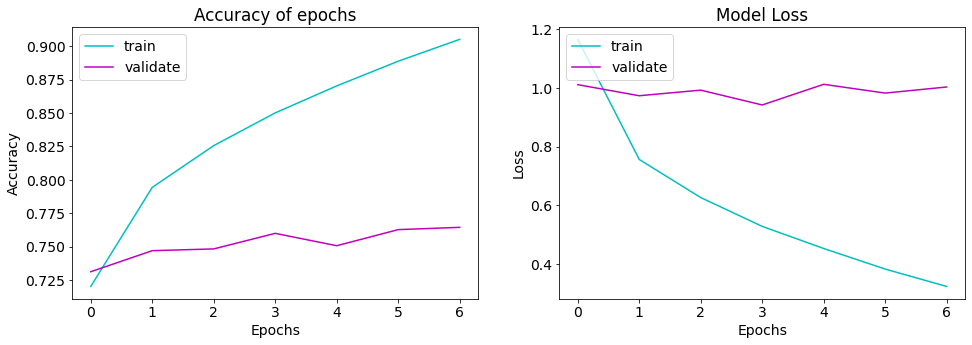

In [ ]:
plot_model(history_2)

In [ ]:
result_2 = pd.DataFrame((score_train_2[1], score_test_2[1], score_train_2[0], score_test_2[0], model_time_2)).T
result_2.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss', 'time']
result_2['model'] = 'Xception'

In [ ]:
result_2

,train_accuracy,test_accuracy,train_loss,test_loss,time,model
0,0.93480,0.76390,0.21726,1.00296,6034.18906,Xception


### Запуск предсказания для случайного изображения

In [ ]:
import random

idx = random.randint(0, 100)

image, label = next(iter(test_ds.take(idx)))

In [ ]:
pred_prob = model(image, training=False).numpy()

pred_perc = np.max(pred_prob, axis=1) * 100
pred_label = np.argmax(pred_prob, axis=1)

In [ ]:
image = (image + 1) * 255
image = tf.cast(image, tf.int64)


True Answer:: cheesecake
Predictions: cheesecake
Percent: 99.98%


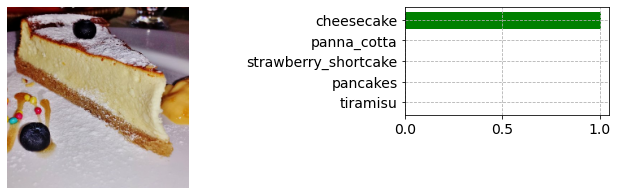


True Answer:: hummus
Predictions: hummus
Percent: 99.91%


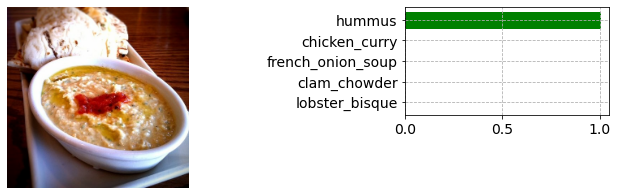


True Answer:: grilled_cheese_sandwich
Predictions: grilled_cheese_sandwich
Percent: 65.65%


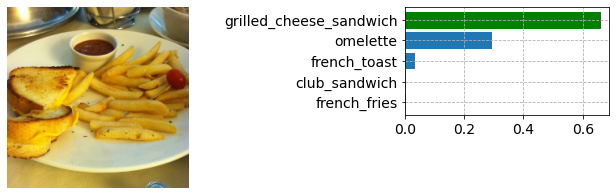


True Answer:: prime_rib
Predictions: prime_rib
Percent: 99.30%


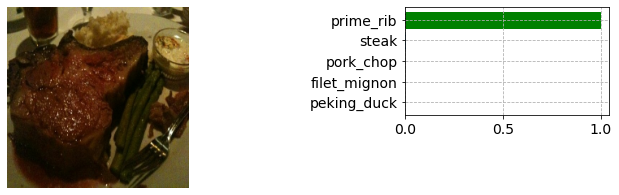


True Answer:: cheese_plate
Predictions: cheese_plate
Percent: 99.96%


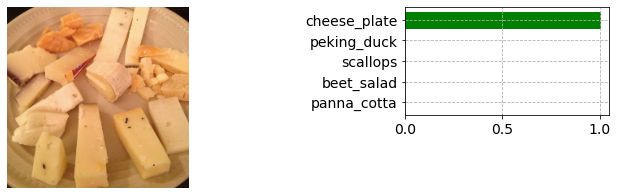

In [ ]:
for i in range(5):
    true = class_names[label[i]]
    pred = class_names[pred_label[i]]
    print(f'\nTrue Answer:: {true}\n',
          f'Predictions: {pred}\n',
          f'Percent: {pred_perc[i]:.2f}%', sep ='')
    
    plt.figure(figsize=(11, 10))
    
    # image
    plt.subplot(3, 2, 1)
    plt.imshow(image[i])
    plt.axis('off')
    
    # accuracy
    plt.subplot(5, 2, 2)
    food_prob = zip(class_names, pred_prob[i])
    food_prob = sorted(food_prob, key=lambda fp: fp[1])[-5:]
    
    food = np.array(food_prob)[:, 0]
    prob = np.array(food_prob)[:, 1].astype(np.float32)
    
    bars = plt.barh(food, prob)

    plt.subplots_adjust(wspace=1, hspace=0)
    
    true_idx = np.where(food == true)[0]
    if true_idx.size:
        bars[true_idx[0]].set_color('g')

    plt.grid(True, linestyle='--')

    plt.show()